In [ ]:
# !pip3 install torch torchvision torchaudio
# !pip3 install pyro-ppl 
# !pip install -U -q PyDrive

In [ ]:
import pandas as pd
import pyro
import torch
import torch.distributions.constraints as constraints
import numpy as np 

from pyro.distributions import Bernoulli, Categorical, Normal, Dirichlet
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive

import matplotlib.pyplot as plt

In [ ]:
# Set up plotting info
color_red = '#fc4f30'
color_yellow = '#e5ae38'
color_green = '#6d904f'
color_blue = '#30a2da'
color_gray = '#8b8b8b'
color_purple = '#8c2587'
plt.style.use('fivethirtyeight')

In [ ]:
# Set pyro seed for reproducibility
pyro.set_rng_seed(0)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Get unsupervised data
# data100k.csv
link_to_csv = "https://drive.google.com/file/d/1TwJ_Cr7I7fap9WtPTONo3vc2uZ98PQ6y/view?usp=sharing"
    
# Get the id part of the file
id = link_to_csv.split("/")[-2]

file_name = "data100k.csv"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file_name)  

In [ ]:
def make_dict_of_tensors(data_unsupervised):
  df_data_unsupervised = pd.DataFrame(data_unsupervised)
  data_unsupervised_dict = {
      'personality': torch.tensor(df_data_unsupervised['personality'].values).float(),
      'herbology': torch.tensor(df_data_unsupervised['herbology'].values).float(),
      'quidditch rank': torch.tensor(
          df_data_unsupervised['quidditch rank'].values).float()
  }
  return data_unsupervised_dict

def make_ground_truth_dict(data_supervised):
  df_data_supervised = pd.DataFrame(data_supervised)
  data_supervised_dict = {
      'house': torch.tensor(df_data_supervised['house'].values).float()}
  return data_supervised_dict

Check to see if unsupervised data is properly read.

In [ ]:
data_unsupervised = pd.read_csv(file_name, delimiter=",")
print(data_unsupervised.head())
print("\n")

data_unsupervised_dict = make_dict_of_tensors(data_unsupervised)
print(f"data set size = {len(data_unsupervised)}")
print(data_unsupervised_dict.keys())

   personality  herbology  quidditch rank
0            0          1       511.89264
1            1          1       290.68973
2            3          1       447.24384
3            2          0       443.54858
4            1          0       325.72040


data set size = 100000
dict_keys(['personality', 'herbology', 'quidditch rank'])


In [ ]:
# Get supervised data
# data100k_ground_truth.csv
link_to_csv = "https://drive.google.com/file/d/17ADASZTM9y7cJSZ4Wr4CCyMASYM6g5CB/view?usp=sharing"

# Get the id part of the file
id = link_to_csv.split("/")[-2]

file_name_truth = "data100k_ground_truth.csv"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file_name_truth)

Check to see if supervised data is properly read.

In [ ]:
correct_house_data = pd.read_csv(file_name_truth, delimiter="\t")
print(correct_house_data.head())
print("\n")
print(f"ground truth data set size = {len(correct_house_data)}")

ground_truth_dict = make_ground_truth_dict(correct_house_data)
print(ground_truth_dict.keys())

   house  personality  herbology  quidditch rank
0      3            0        1.0       511.89264
1      2            1        1.0       290.68973
2      1            3        1.0       447.24384
3      3            2        0.0       443.54858
4      2            1        0.0       325.72040


ground truth data set size = 100000
dict_keys(['house'])


Base the probabilistic model off of the true simulation parameters resulting in the ground truth data in order to see the best case scenario when looking at the impact of data sampling size on accuracy and loss.

In [ ]:
def house_model():
    """Probabilistic model representing generating house data.

    Args: None.

    Returns:
        house_idx: pytorch tensor where the value represents the index corresponding 
                  to a Hogwarts houses.
                  shape: (N)
                          N: number of data points.
    """
    house_idx = pyro.sample("house", Categorical(probs=torch.ones(4)))
    return house_idx

def personality_model(house_idx):
    # "Type A", "Type B", "Type C", "Type D"
    house_probs = torch.tensor(
        [
            [.39, .39, .18, .04], # "Gryffindor"
            [.05, .05, .40, .50], # "Hufflepuff"
            [.39, .39, .18, .04], # "Slytherin"
            [.25, .25, .40, .10]  # "Ravenclaw"
        ]
    )
    probs = house_probs[house_idx]
    personality_idx = pyro.sample(f"personality", Categorical(probs=probs))
    return personality_idx

def herbology_model(house_idx):
    # "Weak", "Strong"
    probs = torch.tensor([.4, .9, .6, .8])
    prob = probs[house_idx]
    herbology = pyro.sample("herbology", Bernoulli(probs=prob))
    return herbology

def quidditch_rank_model(house_idx):
    mus = torch.tensor([580.0, 460.0, 300.0, 500.0])
    scales = torch.tensor(
        [
            mus[0] ** .5,
            mus[1] ** .5,
            2.0 * mus[2] ** .5,
            1.5 * mus[3] ** .5
        ]    
    )
    mu = mus[house_idx]
    scale = scales[house_idx]
    score = pyro.sample("quidditch rank", Normal(mu, scale))
    return score

In [ ]:
def model(N):
    with pyro.plate("iid", N):
        house = house_model()
        personality = personality_model(house)
        herbology = herbology_model(house)
        quidditch_rank = quidditch_rank_model(house)
    return personality, herbology, quidditch_rank

print(model(10))

(tensor([1, 0, 2, 2, 1, 1, 1, 2, 1, 3]), tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]), tensor([458.3175, 283.5029, 445.2887, 449.5160, 308.8329, 560.5164, 569.1569,
        449.6401, 322.7837, 480.1320]))


In [ ]:
def guide(N):
    parameters = pyro.param(
        'house probs',
        lambda: Dirichlet(1/4 * torch.ones(4)).sample([N]),
        constraint=constraints.simplex
    )
    with pyro.plate("iid", N):
        house_idx = pyro.sample("house", Categorical(probs=parameters))

In [ ]:
def calculate_accuracy(data, correct_house_data):
      # get the most probable house by taking the maximum probability
      house_predictions = torch.max(pyro.param('house probs'), dim=1)[1]
      # match up the supervised and unsupervised data sets through their index
      houses_correct = torch.tensor(
          (correct_house_data["house"].loc[data.index]).values)
      
      # tally correctly identified houses
      num_correct = torch.where(
          house_predictions == houses_correct, 
          torch.ones_like(houses_correct),
          torch.zeros_like(houses_correct)
          ).sum()
          
      N = data.shape[0]
      accuracy = (num_correct.item())*100 / N
      return accuracy

In [ ]:
def run_svi(model, guide, data, data_dict, correct_house_data, num_time_steps, opt_params, optimizer, criterion):
    # Clear out params
    pyro.clear_param_store()

    # Condition model on data
    conditioned_model = pyro.condition(model, data_dict)
    N = data.shape[0]

    # Set svi parameters
    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=optimizer,
        loss=criterion
    )

    # Run svi for each time step
    accuracies = []
    losses = []
    for i in range(num_time_steps):
      current_loss = svi.step(N)
      accuracy = calculate_accuracy(data, correct_house_data)

      losses.append(current_loss)
      accuracies.append(accuracy)
    return losses, accuracies

In [ ]:
def report_quantiles(name, sample_size, mean, quantile_05, quantile_95, magnitude):
    print(f"Sampe Size         = {sample_size}")
    print(f"mean {name} estimate = {mean:.2f}")
    print(f" 5 % quantile      = {quantile_05:.2f}")
    print(f"95 % quantile      = {quantile_95:.2f}")
    print(f"magnitude of error = {magnitude:.0f}")
    print("\n")

def calculate_quantiles(name, samples, sample_size, norm=False):
    mean_estimate = np.mean(samples)
    quantile_05, quantile_95 = np.quantile(samples, [.05, .95])
    lower_error = mean_estimate - quantile_05
    higher_error = quantile_95 - mean_estimate

    if norm:
        denom_sample_size = sample_size
    else:
        denom_sample_size = 1.0

    mean_estimate = mean_estimate / denom_sample_size
    quantile_05 = quantile_05 / denom_sample_size
    quantile_95 = quantile_95 / denom_sample_size
    lower_error = lower_error / denom_sample_size
    higher_error = higher_error / denom_sample_size
    magnitude = quantile_95 - quantile_05

    report_quantiles(
        name, sample_size, mean_estimate, quantile_05, quantile_95, magnitude)

    return mean_estimate, lower_error, higher_error

In [ ]:
# Set optimization parameters for SVI run
opt_params = {"lr": 0.01}
optimizer = Adam(opt_params)
criterion = Trace_ELBO()

# Set bootstrap and data sampling sizes
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000, 25000, 50000]
num_time_steps = 10
boot_size = 3

# Initialize containers for plotting statistics
loss_estimates = []
loss_lowers = []
loss_highers = []

acc_estimates = []
acc_lowers = []
acc_highers = []
pyro.clear_param_store()

# For each data sample size run the model for the bootstrap amount of runs
for sample_size in sample_sizes:
  loss_samples = []
  accuracy_samples = []
  for i in range(boot_size):
    # sample data
    bootstrap_data = data_unsupervised.sample(n=sample_size, replace=True)
    bootstrap_dict = make_dict_of_tensors(bootstrap_data)
    # run the SVI training loop for each bootstrap
    losses, accuracies = run_svi(
        model, guide, bootstrap_data, bootstrap_dict, correct_house_data, 
        num_time_steps, opt_params, optimizer, criterion)
    
    # calcuate loss and accuracy per bootstrap 
    loss_mean = np.array(losses).mean().item()
    loss_samples.append(loss_mean)
    acc_mean = np.array(accuracies).mean().item()
    accuracy_samples.append(acc_mean)

  # Loss statistics
  loss_mean_estimate, loss_lower_error, loss_higher_error = calculate_quantiles(
      "loss", loss_samples, sample_size, norm=True)
  # Log loss statistics 
  loss_estimates.append(loss_mean_estimate)
  loss_lowers.append(loss_lower_error)
  loss_highers.append(loss_higher_error)

  # Accuracy statistics
  acc_mean_estimate, acc_lower_error, acc_higher_error = calculate_quantiles(
      "acc ", accuracy_samples, sample_size, norm=False)
  # Log accuracy statistics 
  acc_estimates.append(acc_mean_estimate)
  acc_lowers.append(acc_lower_error)
  acc_highers.append(acc_higher_error)
  print("\n\n\n")

All sample sizes ran:
[10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000, 25000, 50000]


All mean loss estimates:
[17.25, 22.89, 19.19, 20.43, 21.27, 21.35, 21.29, 21.12, 21.25, 21.26, 21.25]




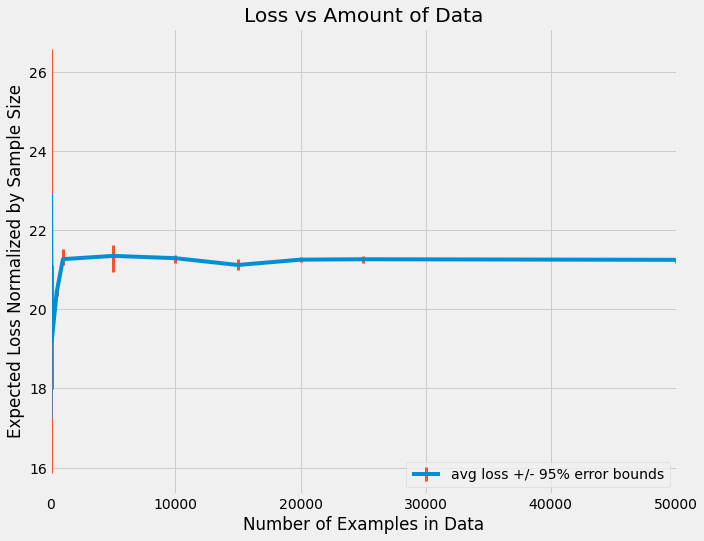

In [ ]:
# Show Loss Estimates
print(f"All sample sizes ran:\n{sample_sizes}")
print("\n")
round_mean_loss = np.round(np.array(loss_estimates), 2).tolist()
print(f"All mean loss estimates:\n{round_mean_loss}")
print("\n")

# Plot Loss Sensitivity
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, max(sample_sizes)+100)

plt.title('Loss vs Amount of Data')
plt.xlabel("Number of Examples in Data")
plt.ylabel("Expected Loss Normalized by Sample Size")

plt.errorbar(
    sample_sizes, 
    loss_estimates, 
    yerr=np.array([loss_lowers, loss_highers]), 
    ecolor=color_red, 
    elinewidth=3.0,
    label = "avg loss +/- 95% error bounds")

plt.legend(loc='lower right')

All sample sizes ran:
[10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000, 25000, 50000]


All mean accuracy estimates:
[40.0, 20.67, 25.3, 27.95, 24.79, 25.12, 25.32, 25.57, 25.25, 25.3, 25.21]




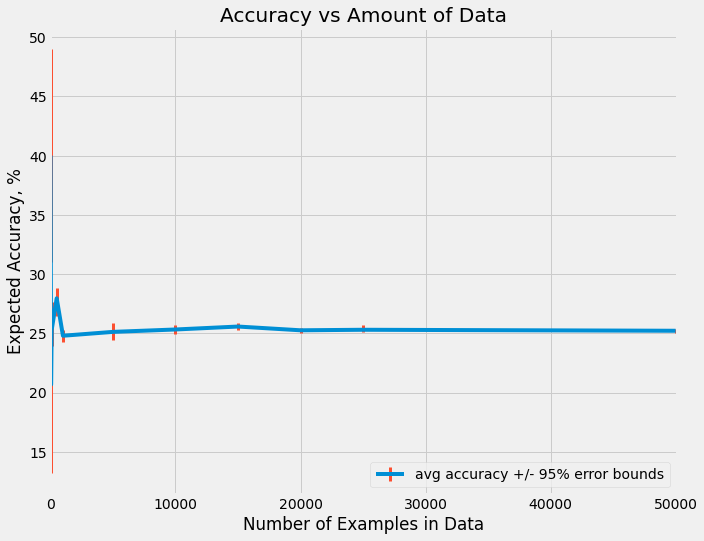

In [ ]:
# Show Accuracy Estimates
print(f"All sample sizes ran:\n{sample_sizes}")
print("\n")
round_mean_acc = np.round(np.array(acc_estimates), 2).tolist()
print(f"All mean accuracy estimates:\n{round_mean_acc}")
print("\n")

# Plot Accuracy Sensitivity
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(0, max(sample_sizes)+100)

plt.title('Accuracy vs Amount of Data')
plt.xlabel("Number of Examples in Data")
plt.ylabel("Expected Accuracy, %")

plt.errorbar(
    sample_sizes, 
    acc_estimates, 
    yerr=np.array([acc_lowers, acc_highers]), 
    ecolor=color_red, 
    elinewidth=3.0,
    label = "avg accuracy +/- 95% error bounds")

plt.legend(loc='lower right')